###Installs and Imports

In [1]:
!pip install sktime
!pip install missingno

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 679.9 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 572.1 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 235.3 kB/s eta 0:00:001m236.7 kB/s eta 0:00:01


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import missingno as msno

### Data Loading

In [4]:
req_cols = ['id', 'date', 'pressure', 'humidity', 'temperature', 'precipitation', 'station',
            'wind_speed', 'dew_point', 'wind_direction', 'solar', 'soil_moisture']
numerical_features = ['pressure', 'humidity', 'temperature', 'precipitation', 'dew_point',\
                      'wind_speed', 'wind_direction', 'solar', 'soil_moisture']
categorical_features = ['Anomaly Prediction', 'Sensor Anomaly']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path_ =  '/content/drive/MyDrive/Similie/data/combined.csv'

In [8]:
tf = pd.read_csv(path_, usecols=req_cols,\
                 dtype={'pressure': np.float64, 'humidity': np.float64,\
                                    'temperature': np.float64, 'precipitation': np.float64,\
                                    'wind_speed': np.float64, 'soil_moisture': np.float64,\
                                    'wind_direction': np.float64, 'solar': np.float64,\
                                     'station': int, 'dew_point': np.float64}, chunksize=1000, iterator=True)
df = pd.concat(tf, ignore_index=True)
df.date = pd.to_datetime(df.date)

In [9]:
raw = df[(df['station'] == 27) & (df['date'].dt.year.isin([2022, 2023]))].copy()
raw = raw.drop_duplicates()
raw = raw.set_index('date', drop=True)

In [10]:
ts = df[(df['station'] == 27) & (df['date'].dt.year.isin([2022, 2023]))].copy()
ts = ts.drop_duplicates()
ts = ts.set_index('date', drop=True)

### Track Sensor Anomalies and Remove Outliers

In [11]:
ts['Sensor Anomaly'] = (ts[numerical_features] < 0).any(axis=1).astype(int)

In [12]:
def z_score(df, numerical_features, threshold):
    for col in numerical_features:
        print(f'Processing {col} with a threshold of {threshold}...')
        score = (df[col] - df[col].mean()) / df[col].std()
        df[col].iloc[np.where(score.abs() > threshold)] = np.nan

In [13]:
z_score(ts, numerical_features, 4)
while ts[ts['temperature'] == ts['temperature'].max()].iloc[0, ts.columns.get_loc('temperature')] >= 55:
  ident = ts[ts['temperature'] == ts['temperature'].max()].index[0]
  print(f"Removing outlier from {ident}...")
  ts.loc[ident, 'temperature'] = np.nan
# we shouldn't have a max value of 230 degrees celsius.

Processing pressure with a threshold of 4...
Processing humidity with a threshold of 4...
Processing temperature with a threshold of 4...
Processing precipitation with a threshold of 4...
Processing dew_point with a threshold of 4...
Processing wind_speed with a threshold of 4...
Processing wind_direction with a threshold of 4...
Processing solar with a threshold of 4...
Processing soil_moisture with a threshold of 4...


<ipython-input-12-00b37d6a04dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].iloc[np.where(score.abs() > threshold)] = np.nan


Removing outlier from 2022-04-08 08:46:50+00:00...
Removing outlier from 2022-05-23 23:58:49+00:00...
Removing outlier from 2023-08-31 22:38:15+00:00...
Removing outlier from 2022-06-22 23:50:49+00:00...
Removing outlier from 2023-09-08 22:12:04+00:00...


Note: removing the "outliers" before scaling is less dangerous. If we scale first, then remove outliers, we might bias the distribution. We could try the sklearn RobustScaler, but for now, Min Max works.

How can dew point have negative values?


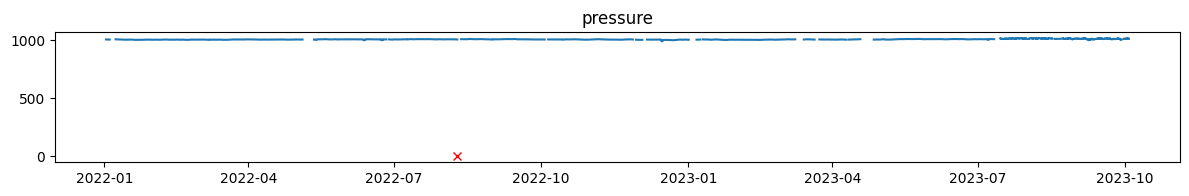

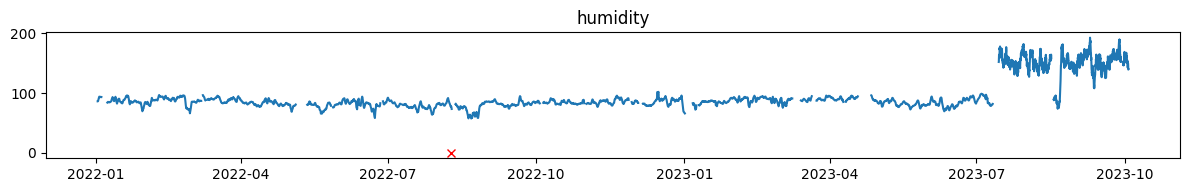

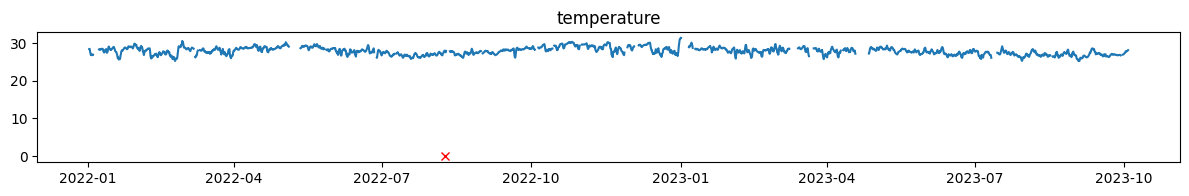

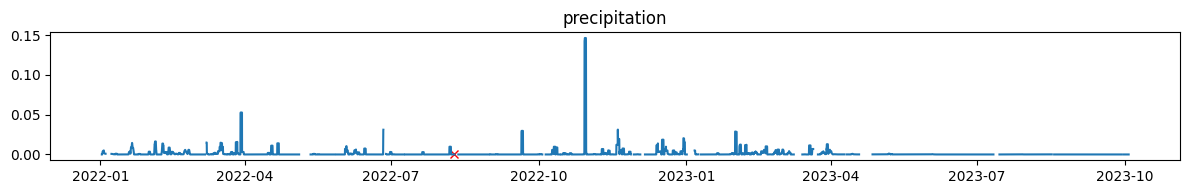

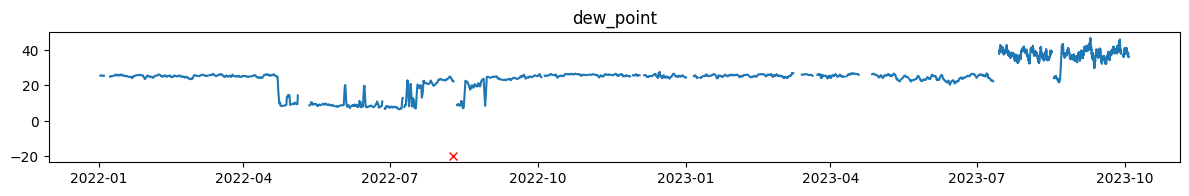

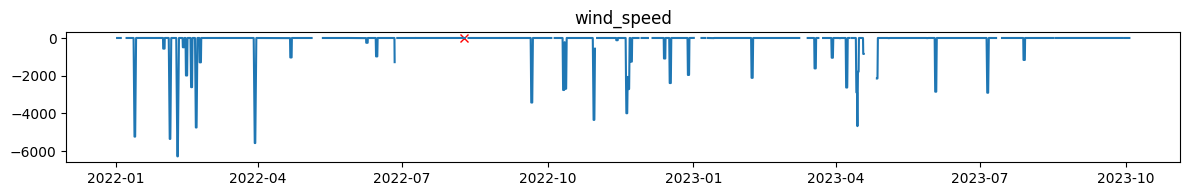

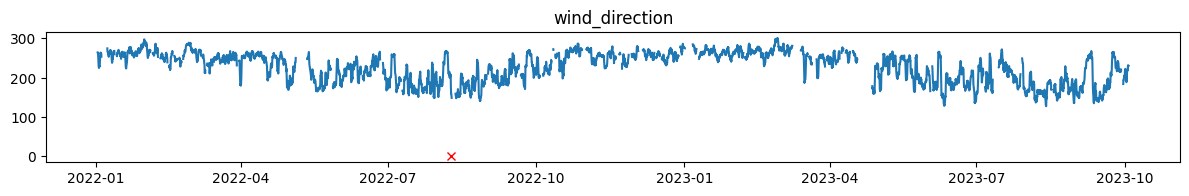

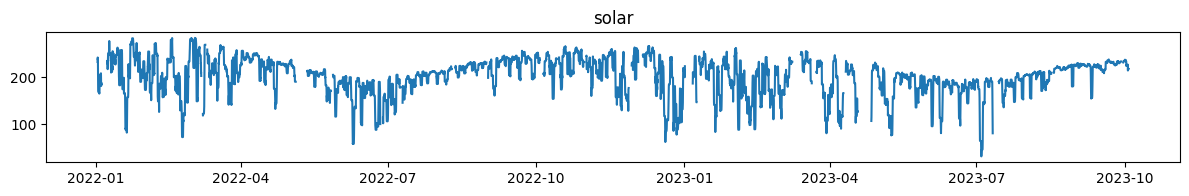

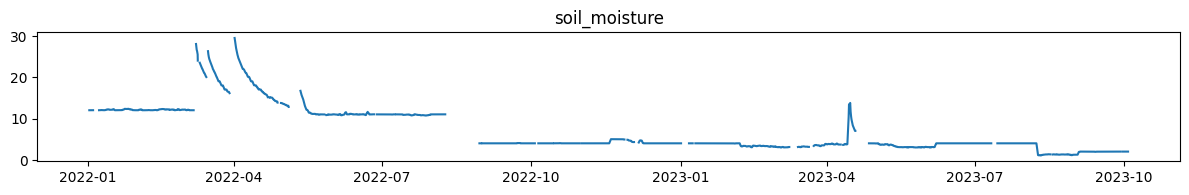

In [14]:
dew_anomaly = ts[ts['dew_point'] < 0]

# Plot time series for neg dew point anomalies
for feat in numerical_features:
  _ = plt.figure(figsize=(12,2))
  _ = plt.plot(dew_anomaly[feat], marker='x', linestyle='None', color='red')
  _ = plt.plot(ts[feat].resample('H').mean().rolling(window=24).mean())
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  _ = plt.title(feat)
print("How can dew point have negative values?")
plt.show();


In [15]:
for feat in numerical_features:
  ts[feat][ts[feat] < 0] = np.nan

<ipython-input-15-6ccdb9c53486>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts[feat][ts[feat] < 0] = np.nan


In [16]:
ts.describe()

,id,pressure,humidity,temperature,precipitation,soil_moisture,wind_speed,wind_direction,station,solar,dew_point,Sensor Anomaly
count,8.557450e+05,855724.000000,855743.000000,855594.000000,855740.000000,821113.000000,843068.000000,843067.000000,855745.0,855723.000000,855737.000000,855745.000000
mean,3.841317e+06,1007.876212,92.360240,27.813324,0.001409,7.228439,1.872398,227.737857,27.0,200.925635,24.199017,0.014815
std,8.103143e+05,31.990029,126.292255,2.153358,0.068209,5.428416,1.656996,90.689230,0.0,284.398431,26.324826,0.120813
min,2.315411e+06,0.000000,0.000000,0.000000,0.000000,1.000000,0.030000,0.400000,27.0,0.000000,1.340000,0.000000
25%,3.223346e+06,1005.800000,78.500000,26.200000,0.000000,4.000000,0.780000,183.100000,27.0,0.000000,22.180000,0.000000
50%,4.056770e+06,1007.500000,83.600000,27.900000,0.000000,4.000000,1.310000,234.200000,27.0,3.000000,24.460000,0.000000
75%,4.522377e+06,1009.400000,88.500000,29.500000,0.000000,11.000000,2.680000,303.000000,27.0,379.000000,25.800000,0.000000
max,4.998001e+06,1909.480000,1908.170000,45.000000,30.820000,30.000000,359.600000,1947.000000,27.0,1340.000000,827.840000,1.000000


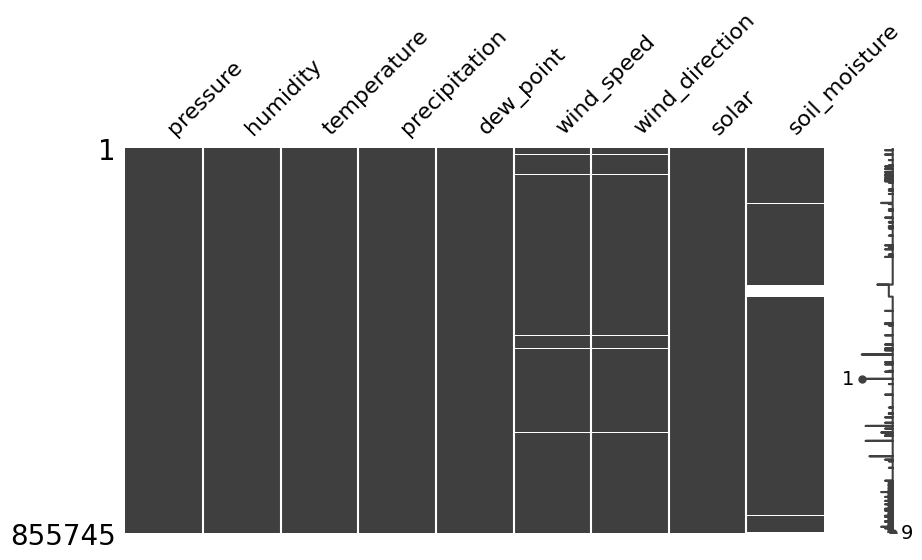

In [17]:
msno.matrix(ts[numerical_features], figsize=(10, 5));

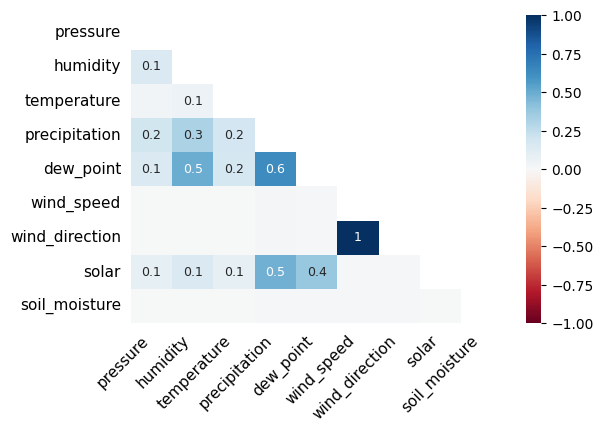

In [18]:
msno.heatmap(ts[numerical_features], figsize=(6, 4), fontsize=11);

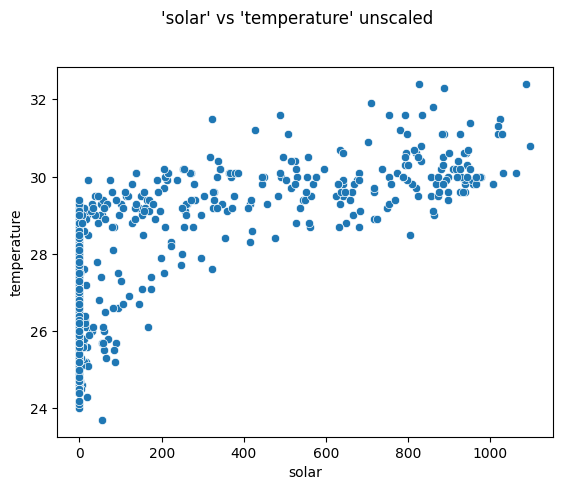

In [19]:
# number of points to visualize to have a clearer plot
num_points_to_plot = 18000
sns.scatterplot(
    data=ts[:num_points_to_plot:30],
    x="solar",
    y="temperature",

)
_ = plt.suptitle(
    "'solar' vs 'temperature' unscaled", y=1
)

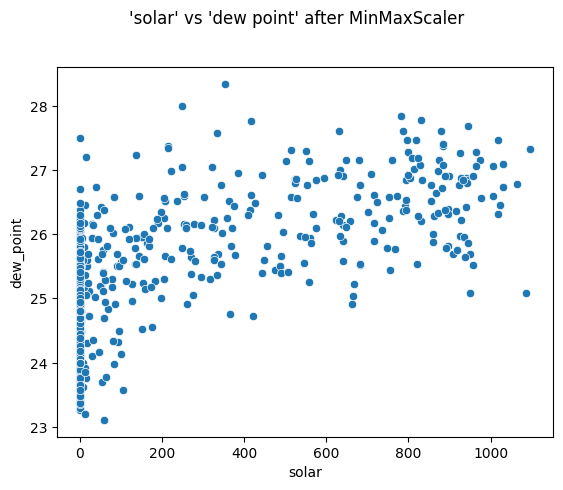

In [20]:
# number of points to visualize to have a clearer plot
num_points_to_plot = 18000
sns.scatterplot(
    data=ts[:num_points_to_plot:30],
    x="solar",
    y="dew_point",
)
_ = plt.suptitle(
    "'solar' vs 'dew point' after MinMaxScaler", y=1
)

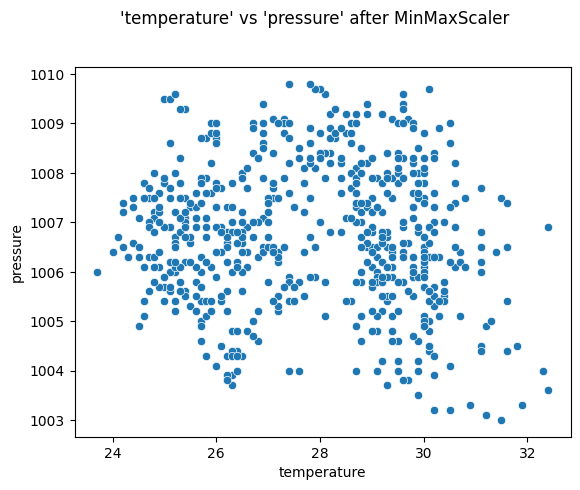

In [21]:
# number of points to visualize to have a clearer plot
num_points_to_plot = 18000
sns.scatterplot(
    data=ts[:num_points_to_plot:30],
    x="temperature",
    y="pressure",

)
_ = plt.suptitle(
    "'temperature' vs 'pressure' after MinMaxScaler", y=1
)

Note: I have heard there is a linear correlation between pressure and temperature. This plot seems to show the opposite. Is there a calibration problem? I will check what happens if we introduce a lag.

In [22]:
def chunkify(df: pd.DataFrame, chunk_size: int):
    start = 0
    length = df.shape[0]

    # If DF is smaller than the chunk, return the DF
    if length <= chunk_size:
        yield df[:]
        return

    # Yield individual chunks
    while start + chunk_size <= length:
        yield df[start:chunk_size + start]
        start = start + chunk_size

    # Yield the remainder chunk, if needed
    if start < length:
        yield df[start:]

In [23]:
ts.isnull().sum()

id                    0
pressure             21
humidity              2
temperature         151
precipitation         5
soil_moisture     34632
wind_speed        12677
wind_direction    12678
station               0
solar                22
dew_point             8
Sensor Anomaly        0
dtype: int64

In [24]:
def most_common(series):
  most = np.bincount(series) if np.bincount(series).size > 0 else 0
  return int(np.argmax(most))

most_common(ts['Sensor Anomaly'])

0

In [25]:
# resample to a fixed ten-minute period
ts = ts.resample('10T').agg({'precipitation': np.sum,
                           'pressure': np.mean,
                           'humidity': np.mean,
                           'wind_speed': np.mean,
                           'wind_direction': np.mean,
                           'solar': np.mean,
                           'dew_point': np.mean,
                           'temperature': np.mean,
                           'soil_moisture': np.mean,
                           'Sensor Anomaly': most_common,
                           'station': most_common
                           })

In [26]:
ts.dtypes

precipitation     float64
pressure          float64
humidity          float64
wind_speed        float64
wind_direction    float64
solar             float64
dew_point         float64
temperature       float64
soil_moisture     float64
Sensor Anomaly      int64
station             int64
dtype: object

<Axes: xlabel='soil_moisture', ylabel='Density'>

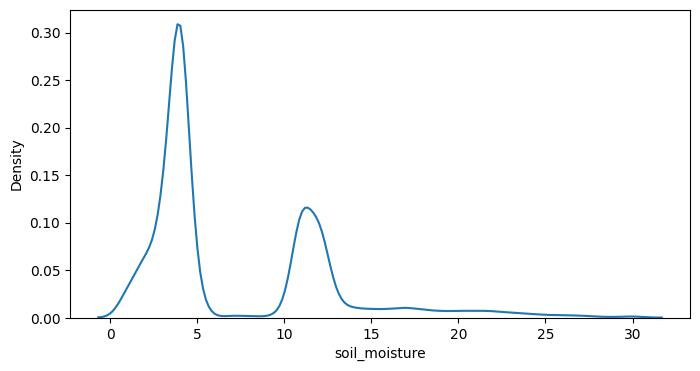

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the original distribution
sns.kdeplot(ts.soil_moisture, label="Original Distribution")

### Iterative Imputer (not using, too much compute)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
ii_imp = IterativeImputer(
    estimator=RandomForestRegressor(), max_iter=12, random_state=1313131
).set_output(transform="pandas")

In [ ]:
# load Data into gen
ts_gen = chunkify(ts, 5_000)

# Fit
count = 1
for kk in ts_gen:
  if count % 2 ==1 & count < 12:
    ii_imp.fit(kk[numerical_features])
  count = count+1

In [ ]:
# Transform
ts_list = []
ts_gen = chunkify(ts, 35_000)
for ee in ts_gen:
    ee[numerical_features] = ii_imp.transform(ee[numerical_features])
    ts_list.append(ee)

In [ ]:
ts_imp = pd.concat(ts_list, ignore_index=True)

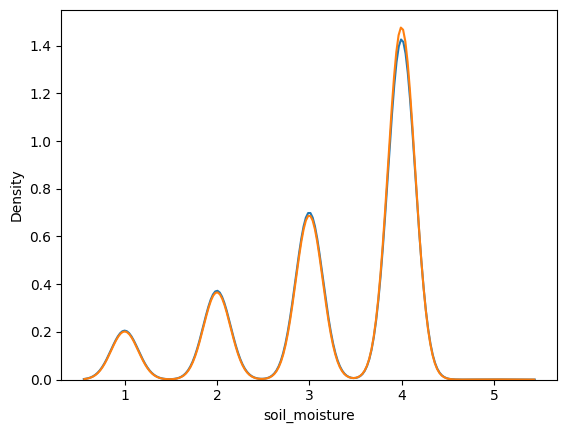

In [ ]:
sns.kdeplot(ts.soil_moisture.loc[::30], label="Original Distribution")
sns.kdeplot(ts_imp.soil_moisture.loc[::30], label="Imputed Distribution");

###Knn Imputer and Min Max Scaling

In [31]:
# n_neighbors = [2, 3, 5, 7]

# fig, ax = plt.subplots(figsize=(8, 4))
# Plot the original distribution
# sns.kdeplot(ts.soil_moisture, label="Original Distribution")
# for k in n_neighbors:
#    ts_knn_imp = ts.copy()
#    knn_imp = KNNImputer(n_neighbors=k)
#    ts_chunk = ts.sample(n=100_000)
#    knn_imp.fit(ts_chunk[numerical_features])
#    ts_knn_imp[numerical_features] = knn_imp.transform(ts[numerical_features])
#    sns.kdeplot(ts_knn_imp.soil_moisture, label=f"Imputed Dist with k={k}")
# plt.legend();

Note: The original data and the imputed versions match well, indicating that the imputer is not changing the overall distribution.

In [32]:
ts.isnull().sum()
# We still have our missing values

precipitation        0
pressure          5096
humidity          5096
wind_speed        6320
wind_direction    6320
solar             5096
dew_point         5096
temperature       5096
soil_moisture     8225
Sensor Anomaly       0
station              0
dtype: int64

In [33]:
ts_ki = ts.copy()

# Init the transformer and scaler
knn_imp = KNNImputer(n_neighbors=3)
scaler = MinMaxScaler().set_output(transform='pandas')

# Fit
chunk = ts.sample(n=40_000)
knn_imp.fit(chunk[numerical_features])

#transform then scale
ts_ki[numerical_features] = knn_imp.transform(ts_ki[numerical_features])
ts_ki[numerical_features] = scaler.fit_transform(ts_ki[numerical_features])
ts_ki.isnull().sum()

precipitation     0
pressure          0
humidity          0
wind_speed        0
wind_direction    0
solar             0
dew_point         0
temperature       0
soil_moisture     0
Sensor Anomaly    0
station           0
dtype: int64

### Isolation Forest Anomaly Detection

In [ ]:
iso_forest = IsolationForest(contamination=0.0001)
iso_forest.fit(ts_ki[numerical_features + ['Sensor Anomaly']])
y_pred = iso_forest.predict(ts_ki[numerical_features + ['Sensor Anomaly']])
y_pred = [1 if x == -1 else 0 for x in y_pred]
np.unique(y_pred, return_counts=True)

In [35]:
ts_ki['Anomaly Prediction'] = y_pred

###Sensor and Predicted Anomaly Plots

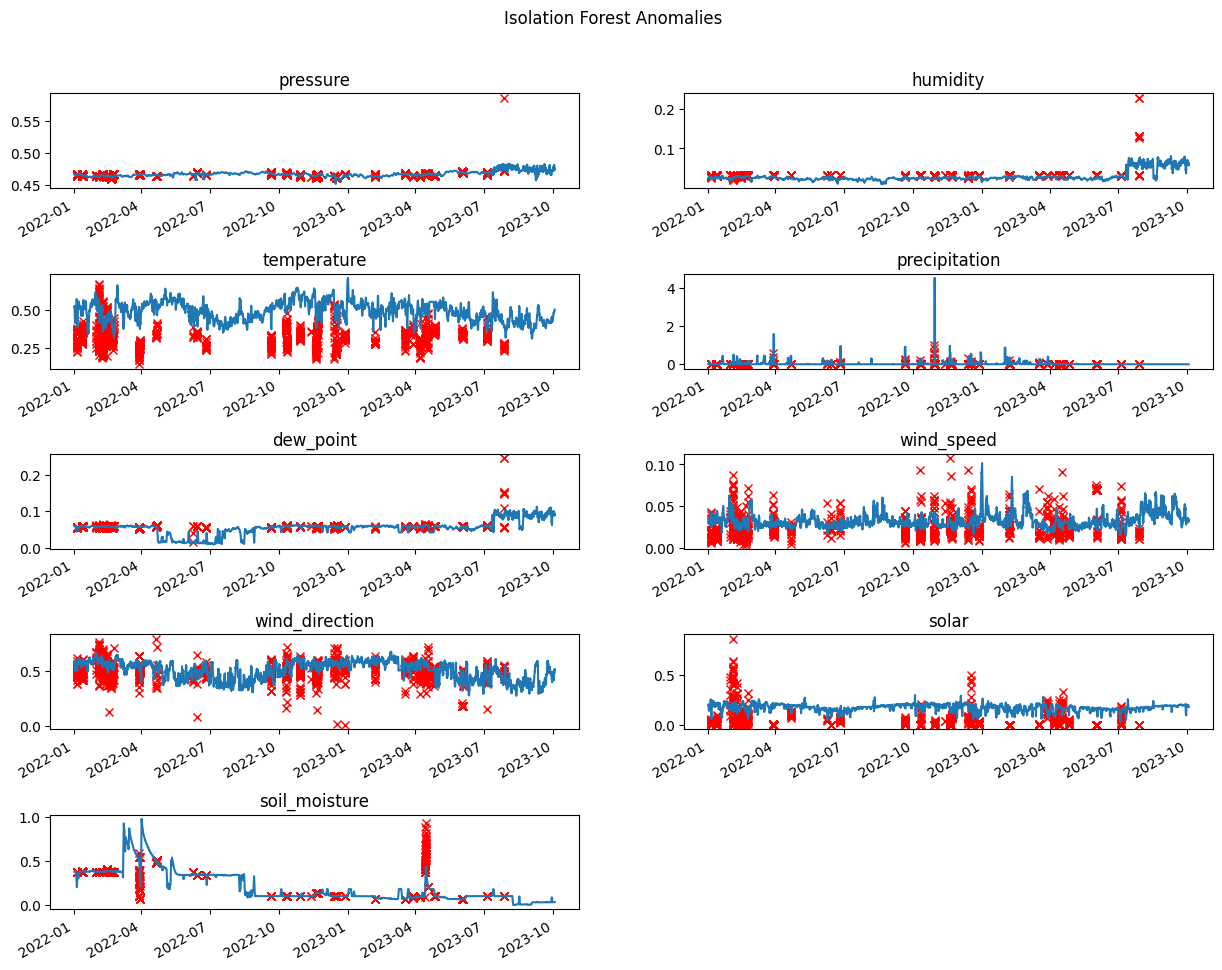

In [79]:
anomaly_pred = ts_ki[ts_ki['Anomaly Prediction'] == 1]

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.9)
plt.suptitle("Isolation Forest Anomalies", fontsize=12, y=0.95)

for n, feat in enumerate(numerical_features):
    ax = plt.subplot(5, 2, n + 1)
    # filter ts_ki and plot on the new subplot axis
    if feat == 'precipitation':
      sensor_anomaly['precipitation'].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki['precipitation'].resample('H').sum().rolling(window=24).sum().plot(ax=ax)
    else:
      sensor_anomaly[feat].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[feat].resample('H').mean().rolling(window=24).mean().plot(ax=ax)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.show();

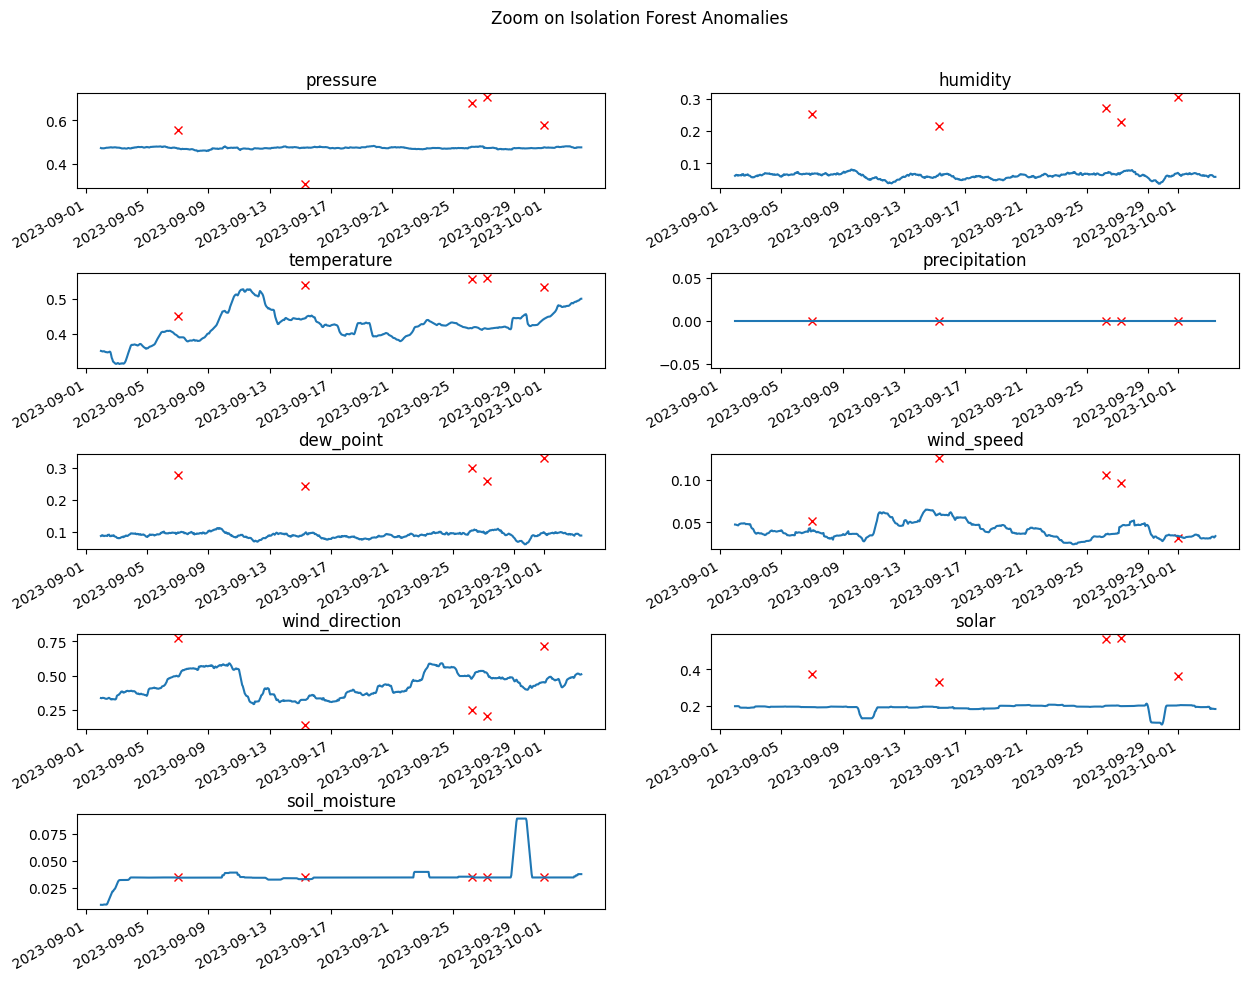

In [82]:
start=datetime(2023, 9, 1, tzinfo=timezone.utc)
end=datetime(2023, 10, 13, tzinfo=timezone.utc)

anomaly_pred = ts_ki[ts_ki['Anomaly Prediction'] == 1]

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.9)
plt.suptitle("Zoom on Isolation Forest Anomalies", fontsize=12, y=0.95)

for n, feat in enumerate(numerical_features):
    ax = plt.subplot(5, 2, n + 1)
    # filter ts_ki and plot on the new subplot axis
    if feat == 'precipitation':
      anomaly_pred[(anomaly_pred.index <= end) & (anomaly_pred.index >= start)]['precipitation'].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[(ts_ki.index <= end) & (ts_ki.index >= start)]['precipitation'].resample('H').sum().rolling(window=24).sum().plot(ax=ax)
    else:
      anomaly_pred[(anomaly_pred.index <= end) & (anomaly_pred.index >= start)][feat].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[(ts_ki.index <= end) & (ts_ki.index >= start)][feat].resample('H').mean().rolling(window=24).mean().plot(ax=ax)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.show();

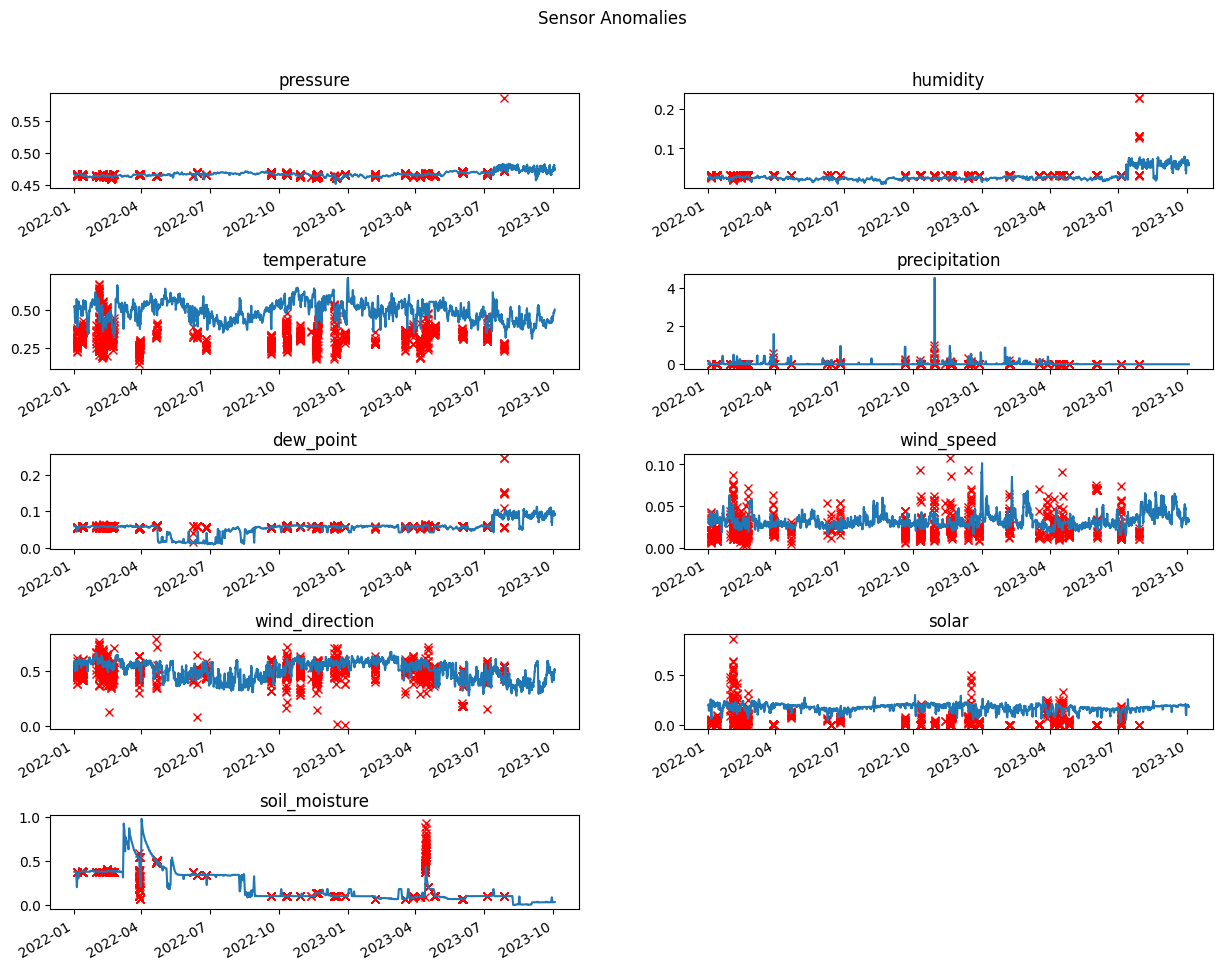

In [80]:
sensor_anomaly = ts_ki[ts_ki['Sensor Anomaly'] == 1]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.9)
plt.suptitle("Sensor Anomalies", fontsize=12, y=0.95)

for n, feat in enumerate(numerical_features):
    ax = plt.subplot(5, 2, n + 1)
    # filter ts_ki and plot on the new subplot axis
    if feat == 'precipitation':
      sensor_anomaly['precipitation'].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki['precipitation'].resample('H').sum().rolling(window=24).sum().plot(ax=ax)
    else:
      sensor_anomaly[feat].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[feat].resample('H').mean().rolling(window=24).mean().plot(ax=ax)
    ax.set_title(feat)
    ax.set_xlabel("")

plt.show();

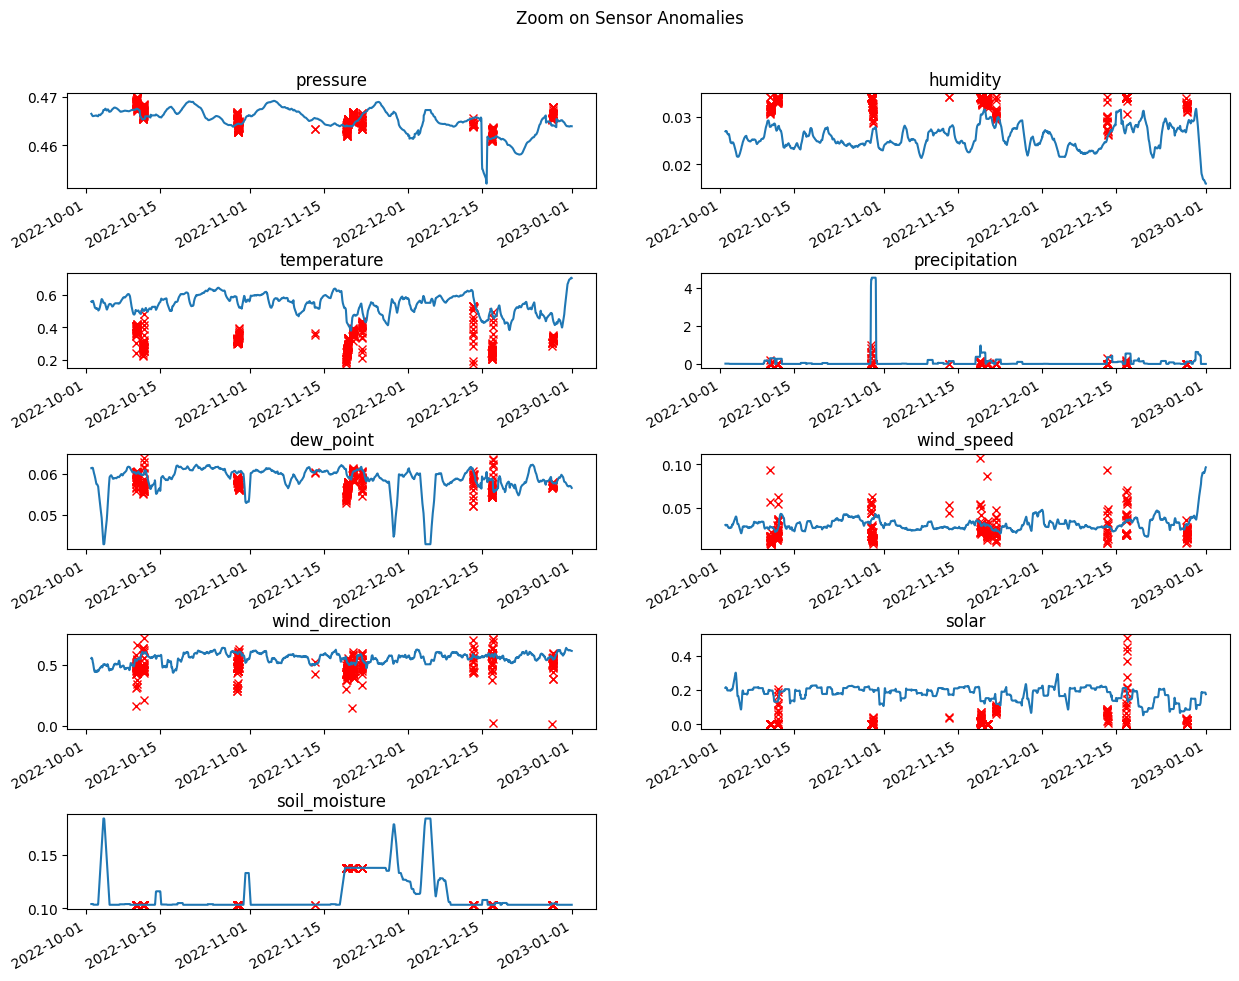

In [83]:
start=datetime(2022, 10, 1, tzinfo=timezone.utc)
end=datetime(2023, 1, 1, tzinfo=timezone.utc)

anomaly_pred = ts_ki[ts_ki['Sensor Anomaly'] == 1]

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.9)
plt.suptitle("Zoom on Sensor Anomalies", fontsize=12, y=0.95)

for n, feat in enumerate(numerical_features):
    ax = plt.subplot(5, 2, n + 1)
    # filter ts_ki and plot on the new subplot axis
    if feat == 'precipitation':
      anomaly_pred[(anomaly_pred.index <= end) & (anomaly_pred.index >= start)]['precipitation'].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[(ts_ki.index <= end) & (ts_ki.index >= start)]['precipitation'].resample('H').sum().rolling(window=24).sum().plot(ax=ax)
    else:
      anomaly_pred[(anomaly_pred.index <= end) & (anomaly_pred.index >= start)][feat].plot(marker='x', linestyle='None', color='red',ax=ax)
      ts_ki[(ts_ki.index <= end) & (ts_ki.index >= start)][feat].resample('H').mean().rolling(window=24).mean().plot(ax=ax)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.show();

###Time Series Analysis

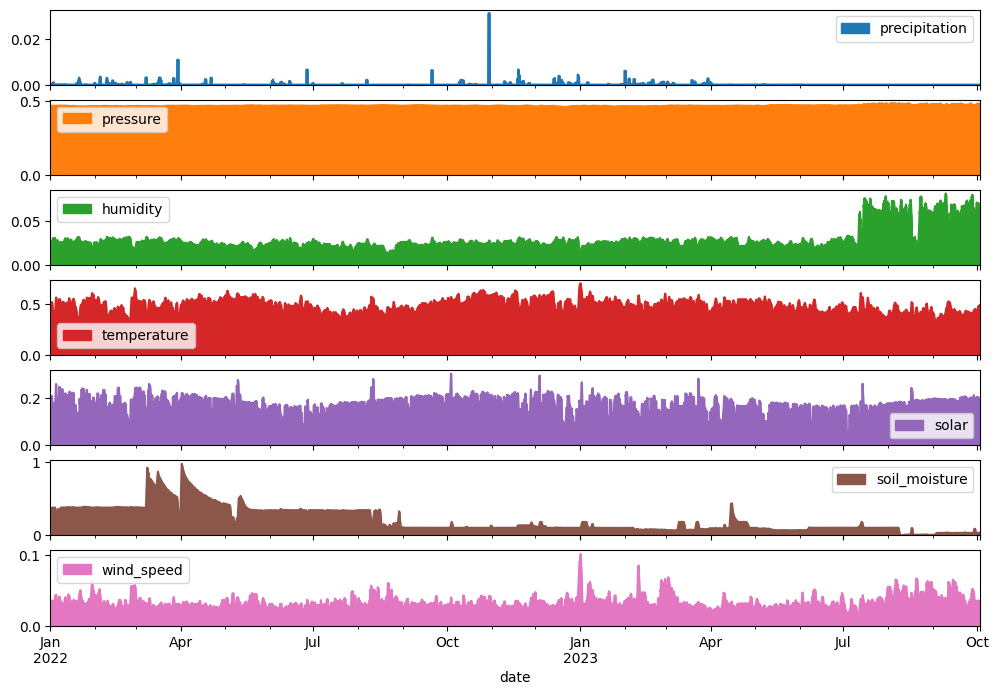

In [52]:
axs = ts_ki[['precipitation',
             'pressure',
             'humidity',
             'temperature',
             'solar',
             'soil_moisture',
             'wind_speed']].resample('H').mean().\
             rolling(window=24).mean().plot.area(figsize=(12, 8), subplots=True)
plt.show();


In [55]:
ts_ki.index

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 00:10:00+00:00',
               '2022-01-01 00:20:00+00:00', '2022-01-01 00:30:00+00:00',
               '2022-01-01 00:40:00+00:00', '2022-01-01 00:50:00+00:00',
               '2022-01-01 01:00:00+00:00', '2022-01-01 01:10:00+00:00',
               '2022-01-01 01:20:00+00:00', '2022-01-01 01:30:00+00:00',
               ...
               '2023-10-03 08:30:00+00:00', '2023-10-03 08:40:00+00:00',
               '2023-10-03 08:50:00+00:00', '2023-10-03 09:00:00+00:00',
               '2023-10-03 09:10:00+00:00', '2023-10-03 09:20:00+00:00',
               '2023-10-03 09:30:00+00:00', '2023-10-03 09:40:00+00:00',
               '2023-10-03 09:50:00+00:00', '2023-10-03 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=92221, freq='10T')

In [90]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from datetime import datetime
from datetime import timezone
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

def stationarity_test(data,
                      value,
                      start=None,
                      end=None,
                      fillna="interpolate",
                      autolag="AIC"):
    time_index = data.index

    # Subset
    if start < min(time_index):
        start = min(time_index)
    if end > max(time_index):
        end = max(time_index)
    subset = data[(time_index >= start) & (time_index <= end)][value]

    if fillna.lower() == "interpolate":
        subset = subset.interpolate()
    elif fillna.lower() == "ffill":
        subset = subset.ffill()
    elif fillna.lower() == "bfill":
        subset = subset.bfill()
    else:
        return f"Invalid fillna parameter. Expected one of interpolate, ffill, bfill, got {fillna}."

    # ADF and KPSS tests
    adf_output=adfuller(subset, autolag=autolag)
    kpss_output=kpss(subset)

    # Parsing results
    def print_results(output, test='adf'):
        '''
        Print results for either "ADF" or "KPSS" tests.
        '''
        pval = output[1]
        test_score = output[0]
        lags = output[2]
        decision = 'Non-Stationary'
        if test == 'adf':
            if pval < 0.05:
                decision = 'Stationary'
        elif test=='kpss':
            if pval >= 0.05:
                decision = 'Stationary'
        output_dict = {
        'Test Statistic': round(test_score, 4),
        'p-value': round(pval, 4),
        'Lags Used': lags,
        'Decision': decision
    }
        return pd.Series(output_dict, name=test)

    results_df=pd.concat([
        print_results(adf_output), print_results(kpss_output, test="kpss")
    ], axis=1)

    return results_df

# Stationarity tests
for feat in numerical_features:
  print(f"{feat}", '\n', stationarity_test(ts_ki.resample('H').mean(),
                  value=feat,
                  start=datetime(2022, 1, 1, tzinfo=timezone.utc),
                  end=datetime(2022, 2, 1, tzinfo=timezone.utc)), '\n')

pressure 
                            adf            kpss
Test Statistic         -1.3876          2.3986
p-value                 0.5882            0.01
Lags Used                   20              16
Decision        Non-Stationary  Non-Stationary 

humidity 
                        adf            kpss
Test Statistic     -7.1413          0.6194
p-value                0.0          0.0209
Lags Used                1              16
Decision        Stationary  Non-Stationary 

temperature 
                            adf        kpss
Test Statistic         -2.6799      0.4539
p-value                 0.0776      0.0539
Lags Used                   20          16
Decision        Non-Stationary  Stationary 

precipitation 
                        adf        kpss
Test Statistic     -4.0733      0.1375
p-value             0.0011         0.1
Lags Used               14          15
Decision        Stationary  Stationary 

dew_point 
                        adf        kpss
Test Statistic     -7.3176   

Analysis: Where the two tests agree, the feature is stationary, ie good for traditional statistical analysis. Where the ADF says stationary and KPSS says not stationary (ie humidity and wind direction), the feature is difference stationary and needs differencing. Where KPSS says stationary and ADF say not stationary (temperature), the feature is trend stationary, and the trend needs to be removed. Our LSTM will not care about stationarity, and on the contrary, might help the model not overfit.

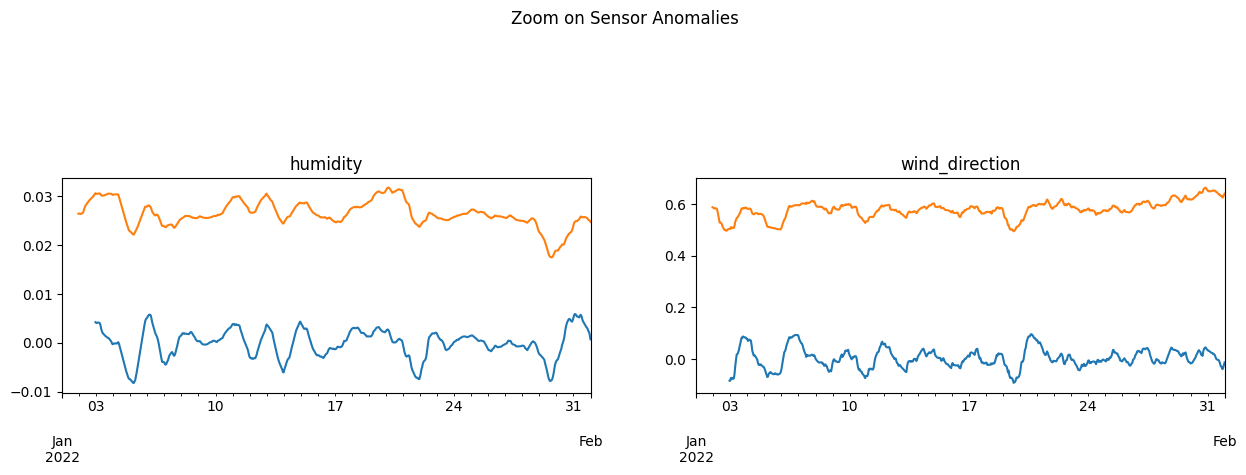

In [117]:
start=datetime(2022, 1, 1, tzinfo=timezone.utc)
end=datetime(2022, 2, 1, tzinfo=timezone.utc)
# d_scale = MinMaxScaler().set_output(transform='pandas')
diff = ts_ki.iloc[:, :9].resample('H').mean().diff(periods=24)
#diff = d_scale.fit_transform(diff)

plt.figure(figsize=(15, 24))
plt.subplots_adjust(hspace=0.9)
plt.suptitle("Zoom on Sensor Anomalies", fontsize=12, y=0.95)

for n, feat in enumerate(['humidity', 'wind_direction']):
    ax = plt.subplot(5, 2, n + 1)
    # filter ts_ki and plot on the new subplot axis
    diff[(diff.index <= end) & (diff.index >= start)].resample('H').mean().rolling(window=24).mean()[feat].plot(ax=ax)
    ts_ki[(ts_ki.index <= end) & (ts_ki.index >= start)][feat].resample('H').mean().rolling(window=24).mean().plot(ax=ax)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.show();

In [119]:
 print(stationarity_test(diff.dropna(),
                  value='humidity',
                  start=datetime(2022, 1, 1, tzinfo=timezone.utc),
                  end=datetime(2022, 2, 1, tzinfo=timezone.utc)))

 # Now with first-order differencing, the humidity and wind direction features read as stationary.

                       adf        kpss
Test Statistic     -8.0808      0.0285
p-value                0.0         0.1
Lags Used               20          16
Decision        Stationary  Stationary


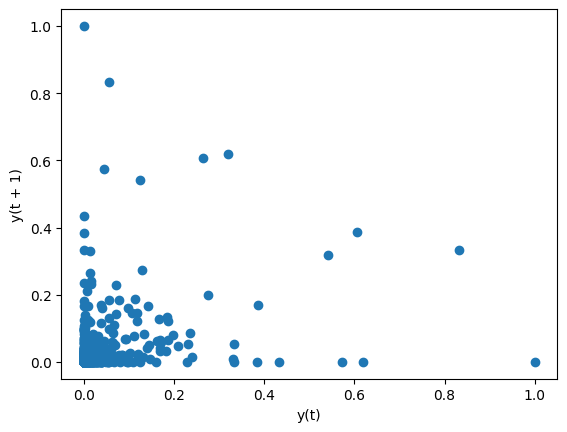

In [91]:
from pandas.plotting import lag_plot
lag_plot(ts_ki['precipitation']);

# Maybe I need to tighten z_scores for
# precipitation outliers

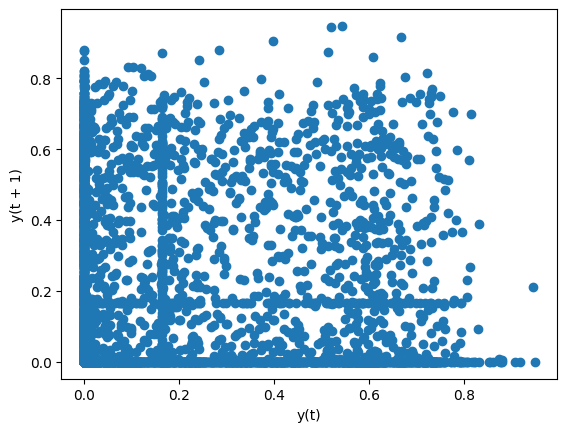

In [92]:
lag_plot(ts_ki['solar'].sample(n=5000));
# weak positive correlation, plus a lot of zeros (nighttime)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

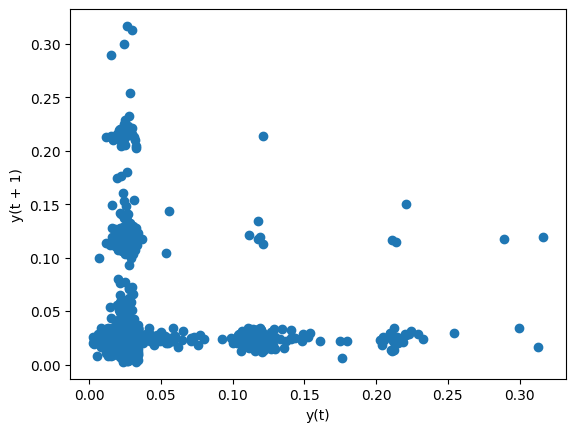

In [123]:
lag_plot(ts_ki['humidity'].sample(n=5000))

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

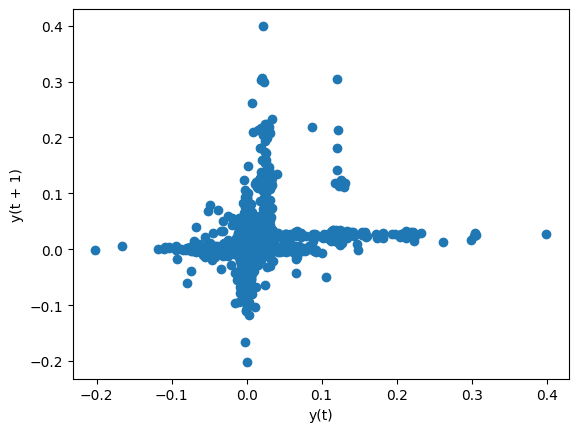

In [122]:
lag_plot(diff['humidity'].sample(n=5000));

In [126]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
from sktime.dists_kernels import FlatDist, ScipyDist
from sktime.utils import plotting

In [128]:
diff = diff.to_period('H')
diff.index

<ipython-input-128-980d785b6e55>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  diff = diff.to_period('H')


PeriodIndex(['2022-01-01 00:00', '2022-01-01 01:00', '2022-01-01 02:00',
             '2022-01-01 03:00', '2022-01-01 04:00', '2022-01-01 05:00',
             '2022-01-01 06:00', '2022-01-01 07:00', '2022-01-01 08:00',
             '2022-01-01 09:00',
             ...
             '2023-10-03 01:00', '2023-10-03 02:00', '2023-10-03 03:00',
             '2023-10-03 04:00', '2023-10-03 05:00', '2023-10-03 06:00',
             '2023-10-03 07:00', '2023-10-03 08:00', '2023-10-03 09:00',
             '2023-10-03 10:00'],
            dtype='period[H]', name='date', length=15371)

In [125]:
from sktime.forecasting.model_selection import temporal_train_test_split

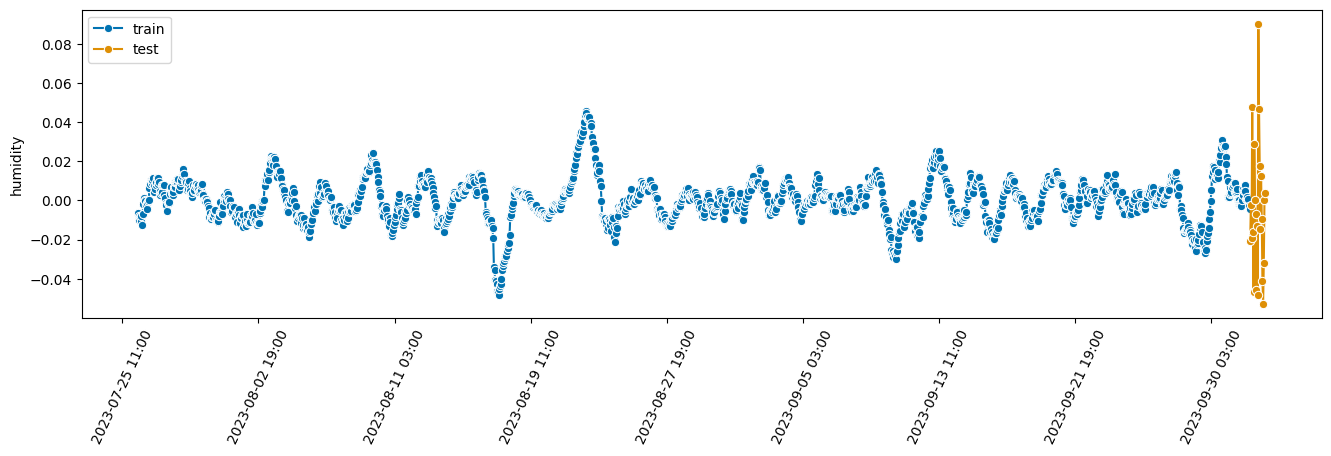

In [130]:
fh = np.arange(1, 24)
y_train, y_test = temporal_train_test_split(diff['humidity'].iloc[-1680:], fh=fh)
fig, ax = plotting.plot_series(y_train[-1680:].rolling(window=24).mean(), y_test, labels=['train', 'test'])
plt.xticks(rotation=65)
ax.legend();

In [131]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

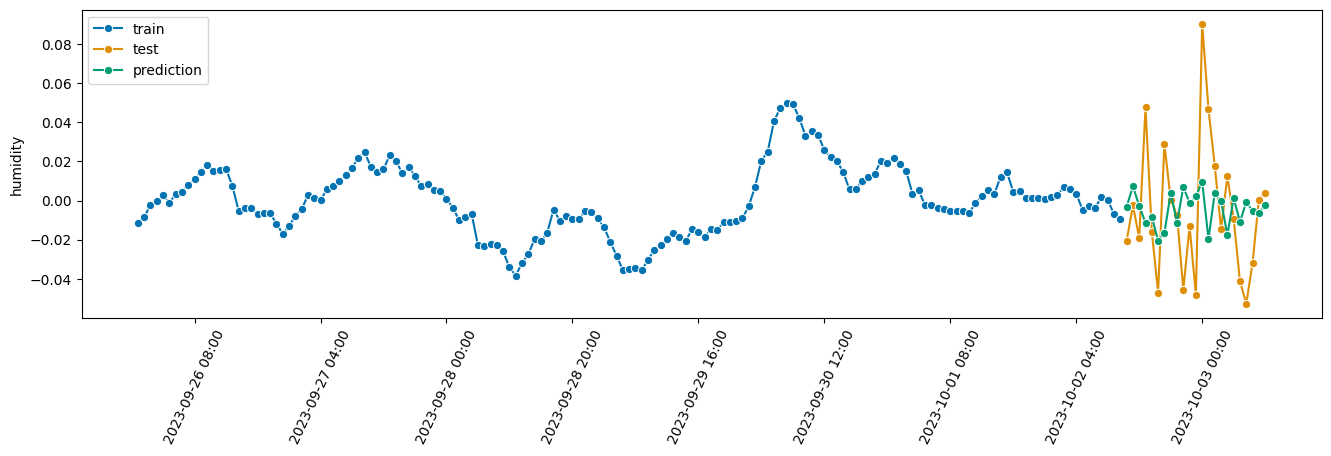

In [132]:
# using sktime to "wrap" a KNN-regressor as a time series forecaster
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy='recursive', window_length=30)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
fig, ax = plotting.plot_series(y_train[-168:].rolling(window=12).mean(), y_test, y_pred, labels=['train', 'test', 'prediction'])
plt.xticks(rotation=65)
ax.legend();

In [133]:
print("Baseline MAPE: \
", mean_absolute_percentage_error(y_test, y_pred, symmetric=False), '\n'\
"Prediction  --> Test")
for idx, line in enumerate(y_pred):
    print(round(line, 2), "  -->  {:>8}".format(y_test.iloc[idx]))

Baseline MAPE:  2.3300787938637475 
Prediction  --> Test
-0.0   -->  -0.02073131619355798
0.01   -->  -0.0025130035458515165
-0.0   -->  -0.019081572501823102
-0.01   -->  0.04762083935805575
-0.01   -->  -0.015941967962512057
-0.02   -->  -0.04702987406264675
-0.02   -->  0.028957022182098655
0.0   -->  0.00033793193103873187
-0.01   -->  -0.007187912979843707
0.01   -->  -0.04558369040843146
-0.0   -->  -0.013272709843993286
0.0   -->  -0.04818186270381779
0.01   -->  0.09036390816501438
-0.02   -->  0.04659673111153714
0.0   -->  0.017597738865188166
-0.0   -->  -0.014566875108481973
-0.02   -->  0.012486300662166994
0.0   -->  -0.009541607464623611
-0.01   -->  -0.041260225603831
-0.0   -->  -0.05277851793662995
-0.01   -->  -0.031871498270076
-0.01   -->  0.0003728608875916764
-0.0   -->  0.003909318553022293
